In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

##If Tensorflow
#from dbn.tensorflow import SupervisedDBNRegression
##If Numpy
from dbn.tensorflow import SupervisedDBNRegression

In [2]:
RBM_EPOCHS = 5
DBN_EPOCHS = 150
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [20, 50, 100]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

In [3]:
# Read the dataset
ROAD = "Taft Ave."
YEAR = "2015"
EXT = ".csv"

##### Preparing Traffic Dataset

In [4]:
TRAFFIC_WINDOWSIZE = 4
TRANSFORMED = True
TRAFFIC_DIR = "../../../datasets/Thesis Datasets/mmda/"

if TRANSFORMED:
    TRAFFIC_FILENAME = "eng_win" + str(TRAFFIC_WINDOWSIZE) + "_mmda_" + ROAD + "_" + YEAR + "_transformed"
else:
    TRAFFIC_FILENAME = "eng_win" + str(TRAFFIC_WINDOWSIZE) + "_mmda_" + ROAD + "_" + YEAR 

traffic_raw_data = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
traffic_dataset = traffic_raw_data
traffic_dataset = traffic_dataset.fillna(0)

cols_to_remove = [0, 1, 2]
statusSN = list(range(5, 19)) #remove all engineered features
cols_to_remove += statusSN

traffic_dataset.drop(traffic_dataset.columns[[cols_to_remove]], axis=1, inplace=True)
traffic_dataset.head()

,statusN,statusS
0,0.231394,0.408168
1,0.237548,0.407201
2,0.243492,0.406253
3,0.249231,0.405322
4,0.254765,0.404408


##### Preparing Weather Dataset

In [5]:
WEATHER_WINDOWSIZE = 3
WEATHER_DIR = "../../../datasets/Thesis Datasets/wwo/"
WEATHER_FILENAME = "eng_win" + str(WEATHER_WINDOWSIZE) + "_wwo_" + YEAR
weather_raw_data = pd.read_csv(WEATHER_DIR + WEATHER_FILENAME + EXT, skipinitialspace=True)
weather_raw_data = weather_raw_data.fillna(0)

weather_dataset = weather_raw_data

cols_to_remove = [0, 1, 2] 

#For Window = >2
temp = list(range(13, 17))
temp2 = list(range(17, 20))
windspeedkmph = list(range(20, 24))
windspeedkmph2 = list(range(24, 27))
cond = list(range(27, 31))
cond2 = list(range(31, 34))
precip = list(range(34, 38))
precip2 = list(range(38, 41))
humid = list(range(41, 45))
humid2 = list(range(45, 48))
visibility = list(range(48, 52))
visibility2 = list(range(52, 55))
pressure = list(range(55, 59))
pressure2 = list(range(59, 62))
cloudcover = list(range(62, 66))
cloudcover2 = list(range(66, 69))
dewpoint = list(range(69, 73))
dewpoint2 = list(range(73, 76))
windgustkmph = list(range(76, 80))
windgustkmph2 = list(range(80, 83))

#Window = 1
#cols_to_remove += temp + visibility + pressure +  cloudcover + dewpoint + windgustkmph #Window = 1
cols_to_remove += temp + windspeedkmph + cond + precip + humid + visibility + pressure +  cloudcover + dewpoint + windgustkmph #Window = 1

#Window  >=2
#cols_to_remove += precip2 + cond2 + humid2 + visibility2 + cloudcover2 + dewpoint2 + windgustkmph2
cols_to_remove +=  temp2 + windspeedkmph2 + cond2 + precip2 + humid2 + visibility2 + pressure2 + cloudcover2 + dewpoint2 + windgustkmph2

# 3 - 12
#cols_to_remove += [7, 8, 9, 10] #Original Weather Variables
#cols_to_remove += [3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #Original Weather Variables

weather_dataset = weather_dataset.drop(weather_dataset.columns[[cols_to_remove]], axis=1)
weather_dataset.head()

,tempC,windspeedKmph,cond,precipMM,humidity,visibility,pressure,cloudcover,dewPointC,windGustKmph
0,0.2000,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.330,0.538462,0.236111
1,0.1875,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.325,0.538462,0.239583
2,0.1750,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.320,0.538462,0.243056
3,0.1625,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.315,0.538462,0.246528
4,0.1500,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.310,0.538462,0.250000


##### Preparing Flood Dataset

In [6]:
FLOOD_WINDOWSIZE = 5
FLOOD_DIR = "../../../datasets/Thesis Datasets/flood/"
FLOOD_FILENAME = "eng_win" + str(FLOOD_WINDOWSIZE) + "_flood_" + YEAR
flood_raw_data = pd.read_csv(FLOOD_DIR + FLOOD_FILENAME + EXT, skipinitialspace=True)
flood_raw_data = flood_raw_data.fillna(0)

cols_to_remove = [0]

flood = [2, 3, 4, 5]
cols_to_remove += flood

flood2 = list(range(6, 9))
cols_to_remove += flood2

flood_dataset = flood_raw_data
flood_dataset = flood_dataset.drop(flood_dataset.columns[cols_to_remove], axis=1)
flood_dataset.head()

,WL [El.m]
0,0.814856
1,0.814856
2,0.814856
3,0.814856
4,0.814856


###### Merging weather and flood

In [7]:
weather_dataset = pd.concat([weather_dataset, flood_dataset], axis=1)
weather_dataset.head()

,tempC,windspeedKmph,cond,precipMM,humidity,visibility,pressure,cloudcover,dewPointC,windGustKmph,WL [El.m]
0,0.2000,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.330,0.538462,0.236111,0.814856
1,0.1875,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.325,0.538462,0.239583,0.814856
2,0.1750,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.320,0.538462,0.243056,0.814856
3,0.1625,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.315,0.538462,0.246528,0.814856
4,0.1500,0.295455,0.631579,0.0,0.84058,1.0,0.758621,0.310,0.538462,0.250000,0.814856


##### Preparing Training Dataset

In [8]:
shift = 1

In [9]:
# To-be Predicted variable 
Y = traffic_dataset.statusS
Y = Y.shift(-shift)
Y = Y.fillna(0)
Y = Y.round(5)
Y = Y[:-shift]

In [10]:
# Other data
X = weather_dataset [:-shift]

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.67, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Data scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

In [11]:
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=HIDDEN_LAYER_STRUCT,
                                    learning_rate_rbm=RBM_LEARNING_RATE,
                                    learning_rate=DBN_LEARNING_RATE,
                                    n_epochs_rbm=RBM_EPOCHS,
                                    n_iter_backprop=DBN_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    activation_function=ACTIVE_FUNC)
regressor.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.372177
>> Epoch 2 finished 	RBM Reconstruction error 0.307257
>> Epoch 3 finished 	RBM Reconstruction error 0.234130
>> Epoch 4 finished 	RBM Reconstruction error 0.203850
>> Epoch 5 finished 	RBM Reconstruction error 0.187857
>> Epoch 1 finished 	RBM Reconstruction error 0.144050
>> Epoch 2 finished 	RBM Reconstruction error 0.115294
>> Epoch 3 finished 	RBM Reconstruction error 0.079783
>> Epoch 4 finished 	RBM Reconstruction error 0.051754
>> Epoch 5 finished 	RBM Reconstruction error 0.040034
>> Epoch 1 finished 	RBM Reconstruction error 0.087443
>> Epoch 2 finished 	RBM Reconstruction error 0.079051
>> Epoch 3 finished 	RBM Reconstruction error 0.067996
>> Epoch 4 finished 	RBM Reconstruction error 0.052557
>> Epoch 5 finished 	RBM Reconstruction error 0.037695
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 0 finished 	ANN training loss 0.034889
>> Epoch 1 finished 	ANN training loss 0.033144
>>

>> Epoch 149 finished 	ANN training loss 0.024889
[END] Fine tuning step


SupervisedDBNRegression(batch_size=28, dropout_p=0, l2_regularization=1.0,
            learning_rate=0.01, n_iter_backprop=150, verbose=True)

In [12]:
#To check RBM Loss Errors:
rbm_error = regressor.unsupervised_dbn.rbm_layers[0].rbm_loss_error
#To check DBN Loss Errors
dbn_error = regressor.dbn_loss_error

In [13]:
# Test
X_test = min_max_scaler.transform(X_test)
Y_pred = regressor.predict(X_test)

r2score = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
print('Done.\nR-squared: %.3f\nRMSE: %.3f \nMAE: %.3f' % (r2score, rmse, mae))

Done.
R-squared: -0.014
RMSE: 0.191 
MAE: 0.142


In [14]:
# Save the model
regressor.save('models/pm2_' + ROAD + '_' + YEAR + '.pkl')

### Results and Analysis below

##### Printing Predicted and Actual Results

In [16]:
startIndex = traffic_raw_data.shape[0] - Y_pred.shape[0]
dt = traffic_raw_data.dt[startIndex:,]
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test, 'dt':dt}

df = pd.DataFrame(data=d)
df.head()

,Actual,Predicted,dt
11563,0.34164,0.214726,01/05/2015 10:45
11564,0.33944,0.212588,01/05/2015 11:00
11565,0.33737,0.210449,01/05/2015 11:15
11566,0.33543,0.208116,01/05/2015 11:30
11567,0.33362,0.205783,01/05/2015 11:45


In [17]:
df.to_csv("output/pm2_" + ROAD + "_" + YEAR + EXT, encoding='utf-8')

#### Visualize trend of loss of RBM and DBN Training

In [18]:
import matplotlib.pyplot as plt

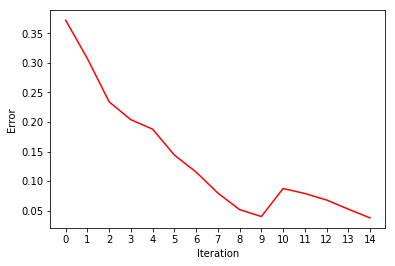

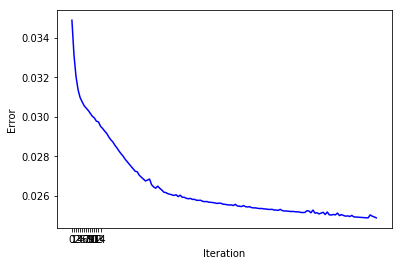

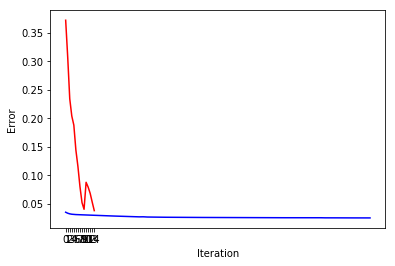

In [19]:
line1 = rbm_error
line2 = dbn_error
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()